# Homework 4
- 姓名： 赵懿
- 学号： 21921266

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib inline

## Test Function
I choose two test functions, the first one is a quite simple func (called QuaFunc in my code): $f(x)=x_1^2+x_2^2$ for:
- it is convex
- its hessian is acutally a fixed one $[[2, 0],[0, 2]]$ ($=2I$, meaning it's postive-definite, invertible)
- optimal solution $x^*=[0, 0]$

The second one is $f(x)=x_1*\exp(-x_1^2-x_2^2)$ (called ExpFunc in my code), the reason I choose this func is that:
- it is not convex, so I can check the LMA using initial point far away from the gloval minimum
- its hessian is complicated (all the elements rely on both $x_1$ and $x_2$)
- it is somehow ... beautiful

For both func, I directly give the gradiant and hessian matrix based on func instead of using the approximate value $f(x+\Delta) - f(x)$. 

Following program is based on the more complciated one (ExpFunc), but you can easily change it to QuaFunc.

In [2]:
class QuaFunc():
    @staticmethod
    def get_value(X):
        return X[0]**2 + X[1]**2
    @staticmethod
    def get_Grad(X):
        return np.array([2*X[0], 2*X[1]])
    @staticmethod
    def get_Hessian(X):
        return np.array([[2, 0], [0, 2]])

class ExpFunc():
    @staticmethod
    def get_value(X):
        return X[0] * np.exp(- X[0]**2 - X[1]**2)
    @staticmethod
    def get_Grad(X):
        com = np.exp(- (X[0]**2) - (X[1]**2))
        return np.array([(1-2*X[0]*X[0])*com, -2*X[0]*X[1]*com])
    @staticmethod
    def get_Hessian(X):
        com = np.exp(- X[0]**2 - X[1]**2)
        h11 = (4*(X[0]**3)-6*X[0])*com
        h12 = (4*(X[0]**2)-2)*X[1]*com
        h21 = (4*(X[0]**2)-2)*X[1]*com
        h22 = (4*(X[1]**2)-2)*X[0]*com
        return np.array([[h11, h12], [h21, h22]])

### Visulize
Let's see how this `ExpFunc` looks like. First plot the surface in area $-2<x_1<2, -2<x_2<2$:

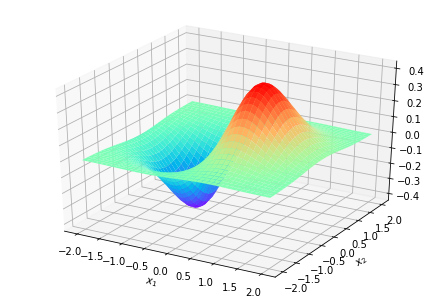

In [3]:
X1, X2=np.mgrid[-2:2:40j,-2:2:40j]
Z = ExpFunc.get_value(np.array([X1.reshape(-1), X2.reshape(-1)]))
Z = Z.reshape(X1.shape)
fig = plt.figure()
ax = Axes3D(fig)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
ax.plot_surface(X1, X2, Z, rstride=1, cstride=1, cmap='rainbow')
plt.show()

According to figure above we can see that it is concex and it does have a global minimum and maxium. If we solve 
equation that grad=0, we'll get two `Stationary Points`, one is global minimum: $[-1/\sqrt{2}, 0]$, the other is global maximum: $[1/\sqrt{2}, 0]$. Then plot the contour of this function in area $-2<x_1<2, -2<x_2<2$:

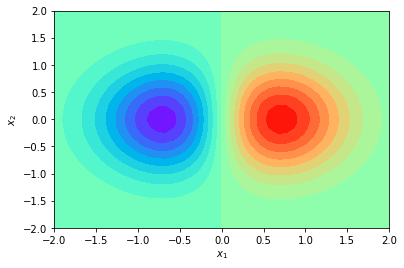

In [4]:
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.contourf(X1, X2, Z, 20, cmap='rainbow')

### LM Algorithm Implement
Then let's implement LMA.

In [10]:
def LM(optFunc, initX, mu, eps, v=4):
    def get_Q(X, J, G, S):
        # X (,dim)
        # J (,dim)
        # G (dim, dim)
        # S (dim, 1)
        return optFunc.get_value(X) + J@S + 0.5*S.T@G@S
    
    X = initX
    dim = initX.shape[0]
    steps = [initX]
    mus = [mu]
    while True:
        J = optFunc.get_Grad(X)
        # print(J)
        if np.all(np.abs(J) < eps):
            break
        G = optFunc.get_Hessian(X)
        H = G + mu*np.eye(dim)
        # update mu
        while (np.any(np.linalg.eigvals(H) <= 0)):
            mu *= v
            H = G + mu*np.eye(dim)
        # compute direction
        S = -np.linalg.inv(H)@J.reshape((dim, 1))
        # update mu
        nextX = X+S.reshape(-1)
        R = (optFunc.get_value(nextX) - optFunc.get_value(X)) / (get_Q(nextX, J, G, S)-get_Q(X, J, G, S))
        if R < 1/v:
            mu *= v
        elif R > 1-1/v:
            mu /= 2
        # update X
        if R>0:
            X = nextX
        mus.append(mu)
        steps.append(X)
    return X, np.array(steps), np.array(mus)

For comparasion, I implement a simple GradDescent alg:

In [20]:
def GradDescent(optFunc, initX, lr, eps):
    X = initX
    dim = initX.shape[0]
    steps = [initX]
    while True:
        J = optFunc.get_Grad(X)
        # print(J)
        if np.all(np.abs(J) < eps):
            break
        # update mu
        X = X-J*lr
        steps.append(X)
    return X, np.array(steps)

Let's start from point $[-2.0,-2.0]$. First test LMA:

-----------LMA-------------
time:
0.0030024051666259766
Iteration number:
11
optimal point:
[-7.06955753e-01  2.16428936e-04]
mus:
[0.01 0.02 0.04 0.08 0.16 0.32 0.16 0.32 0.16 0.08 0.04]


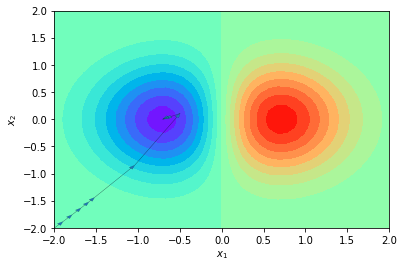

In [41]:
start = time.time()
X, steps, mus = LM(optFunc=ExpFunc, initX=np.array([-2.0,-2.0]), mu=0.01, eps=1e-3)
end = time.time()
print('-----------LMA-------------')
print('time:')
print(end-start)
print('Iteration number:')
print(len(steps))
print('optimal point:')
print(X)
# print('history points:')
# print(steps)
print('mus:')
print(mus)
# plot history points
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.contourf(X1, X2, Z, 20, cmap='rainbow')
for f, l in zip(steps[:-1], steps[1:]):
    d = l - f
    plt.arrow(f[0], f[1], d[0], d[1], shape='full', lw=0.1, length_includes_head=True, head_width=.05)
plt.show()

Next let's test GradDescent:

-----------GradDescent-------------
Iteration number:
82
time:
0.002989053726196289
optimal point:
[-7.06660811e-01 -1.26039290e-11]


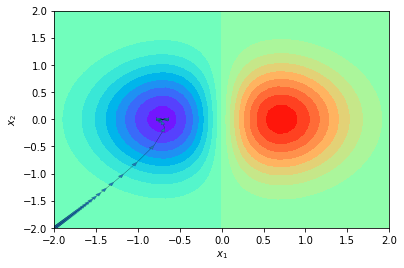

In [29]:
start = time.time()
X, steps = GradDescent(optFunc=ExpFunc, initX=np.array([-2.0,-2.0]), lr=1, eps=1e-3)
end = time.time()
print('-----------GradDescent-------------')
print('Iteration number:')
print(len(steps))
print('time:')
print(end-start)
print('optimal point:')
print(X)
# print('history points:')
# print(steps)
# plot history points
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.contourf(X1, X2, Z, 20, cmap='rainbow')
for f, l in zip(steps[:-1], steps[1:]):
    d = l - f
    plt.arrow(f[0], f[1], d[0], d[1], shape='full', lw=0.1, length_includes_head=True, head_width=.05)
plt.show()

### Conclusion
From above test results, we can conculde (not so accurate):
- Normally, LMA need **much less iterations** than GradDescent, in this program the ratio is 11:82, which meaning LMA converges faster than Grad Descent.
- But because it takes longer time for each iteration of LMA, LMA **does not speed the program up much (3ms:2.99ms in my program)**, at least not in by orders of magnitude. Even in many experiments I did, LMA is even slower than Grad Descent.
- Intuitively, LMA actually **combined the advantages** from both Newton's method and Grad Descent. Because at first, when the gradiant is very small, we can see LMA reduces the $\mu$, making the algorithm more like Newton's method; but when when the gradiant is relatively larger, LMA increase the $\mu$, making the algorithm more like Grad Descent.